# Market Regime Detection

This notebook implements the Kolmogorov-Smirnov (KS) method as proposed by Gómez-Águila et al. (2022) to estimate the Hurst exponent ($H$) of the S&P 500 index and the XEQT ETF.

The Hurst exponent is a measure of long-term memory in time series:
*   $H < 0.5$: Anti-persistent (mean-reverting)
*   $H = 0.5$: Uncorrelated (random walk)
*   $H > 0.5$: Persistent (trending).

Traditional methods like Rescaled Range ($R/S$) often fail with financial data due to heavy-tailed distributions. This notebook utilizes the KS-GHE(1) method, which identifies $H$ by minimizing the Kolmogorov-Smirnov distance between empirical distributions at different scales.

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats, optimize

## KS-GHE(1) Implementation Based on Gómez-Águila et al. (2022)

In [19]:
def samples_GHE(serie, tau):
    return np.abs(serie[tau:] - serie[:-tau])

def samples_TA(serie, tau):
    "Calculates triangle areas for self-similarity testing"
    # Vertices at t, t+tau, and t+2tau
    return (tau / 2.0) * np.abs(serie[2*tau:] - 2*serie[tau:-tau] + serie[:-2*tau])

def KSGHE(serie):
    scaling_range = [2**n for n in range(int(np.log2(len(serie) / 8)) + 1)]

    # Reference distribution at tau=1
    sample_t0 = samples_GHE(serie, scaling_range[0])

    # Minimize the sum of Kolmogorov-Smirnov distances
    # We find the H that makes distributions at different taus match the tau=1 distribution.
    f = lambda h: np.sum([
        stats.ks_2samp(sample_t0, samples_GHE(serie, tau) / (tau**h)).statistic
        for tau in scaling_range[1:]
    ])

    def objective(h):
        return np.sum([
            stats.ks_2samp(sample_t0, samples_GHE(serie, tau) / (tau**h)).statistic
            for tau in scaling_range[1:]
        ])

    # Coarse Grid Search
    grid = np.arange(0.1, 0.9, 17)
    grid_results = [objective(h) for h in grid]
    best_initial_guess = grid[np.argmin(grid_results)]

    # 2. Nelder-Mead to polish the result
    w = optimize.fmin(objective, x0=best_initial_guess, disp=False)
    return w[0]

def self_similarity_test_TA(serie, h_est):
    scaling_range = [2**n for n in range(int(np.log2(len(serie) / 8)) + 1)]

    # Reference distribution is AT(1)
    at1 = samples_TA(serie, 1)
    p_vals = []

    for tau in scaling_range[1:]:
        # Scale triangle areas by tau^(H+1)
        # Use disjoint samples (step size = tau) as required
        at_tau_scaled = samples_TA(serie, tau)[::tau] / (tau**(h_est + 1))
        _, p = stats.ks_2samp(at1, at_tau_scaled)
        p_vals.append(p)

    return min(p_vals)

[*********************100%***********************]  1 of 1 completed



--- Statistics for ^GSPC ---
Mean KS-GHE Hurst: 0.5330
Standard Deviation: 0.0363


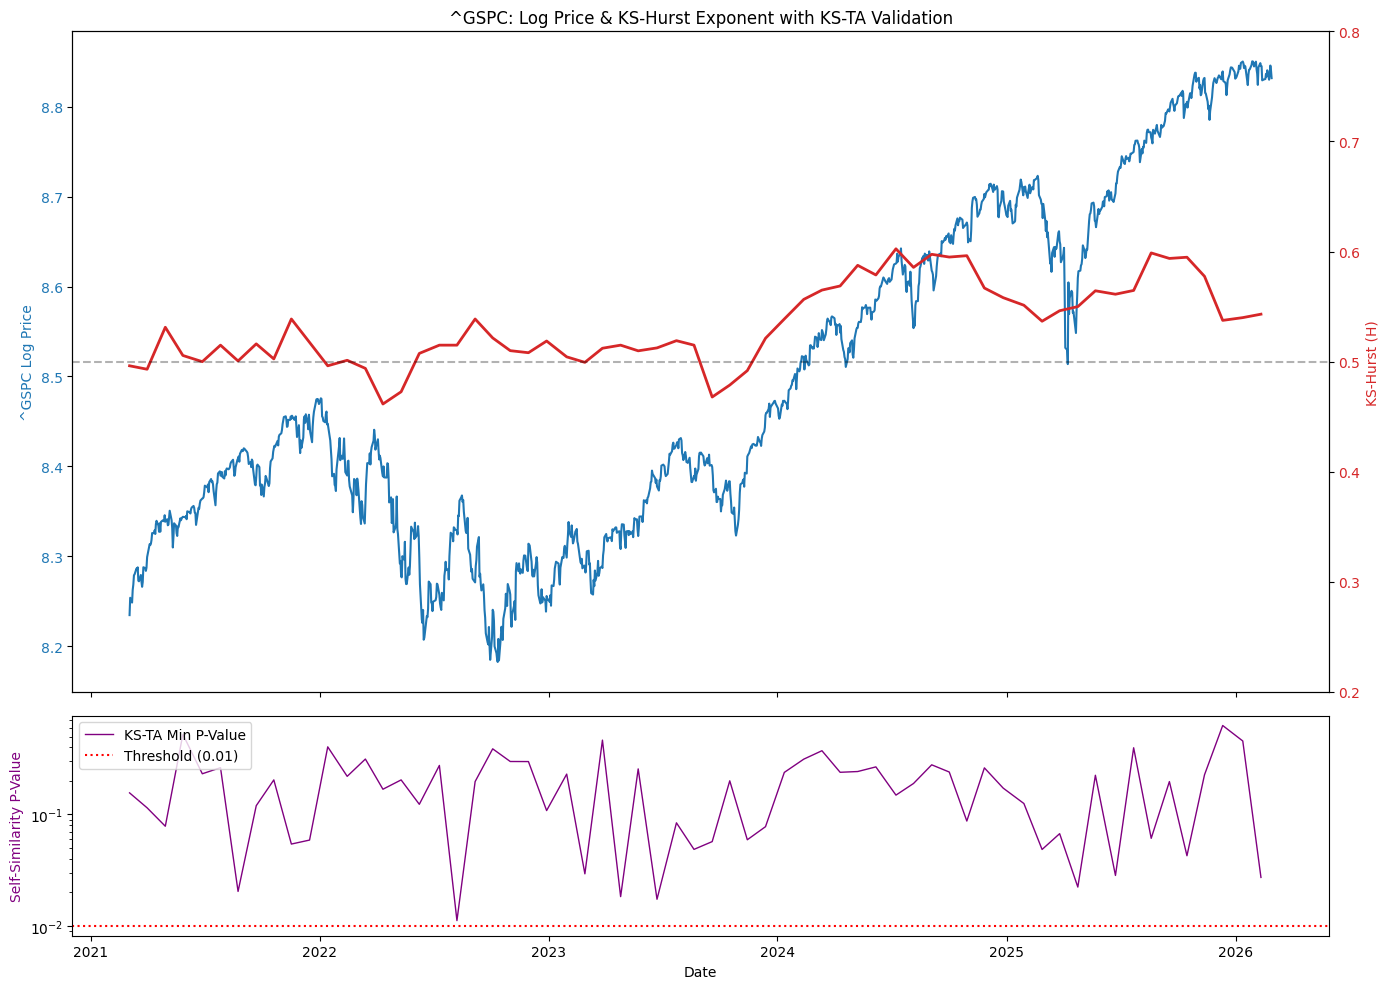

[*********************100%***********************]  1 of 1 completed



--- Statistics for XEQT.TO ---
Mean KS-GHE Hurst: 0.5316
Standard Deviation: 0.0350


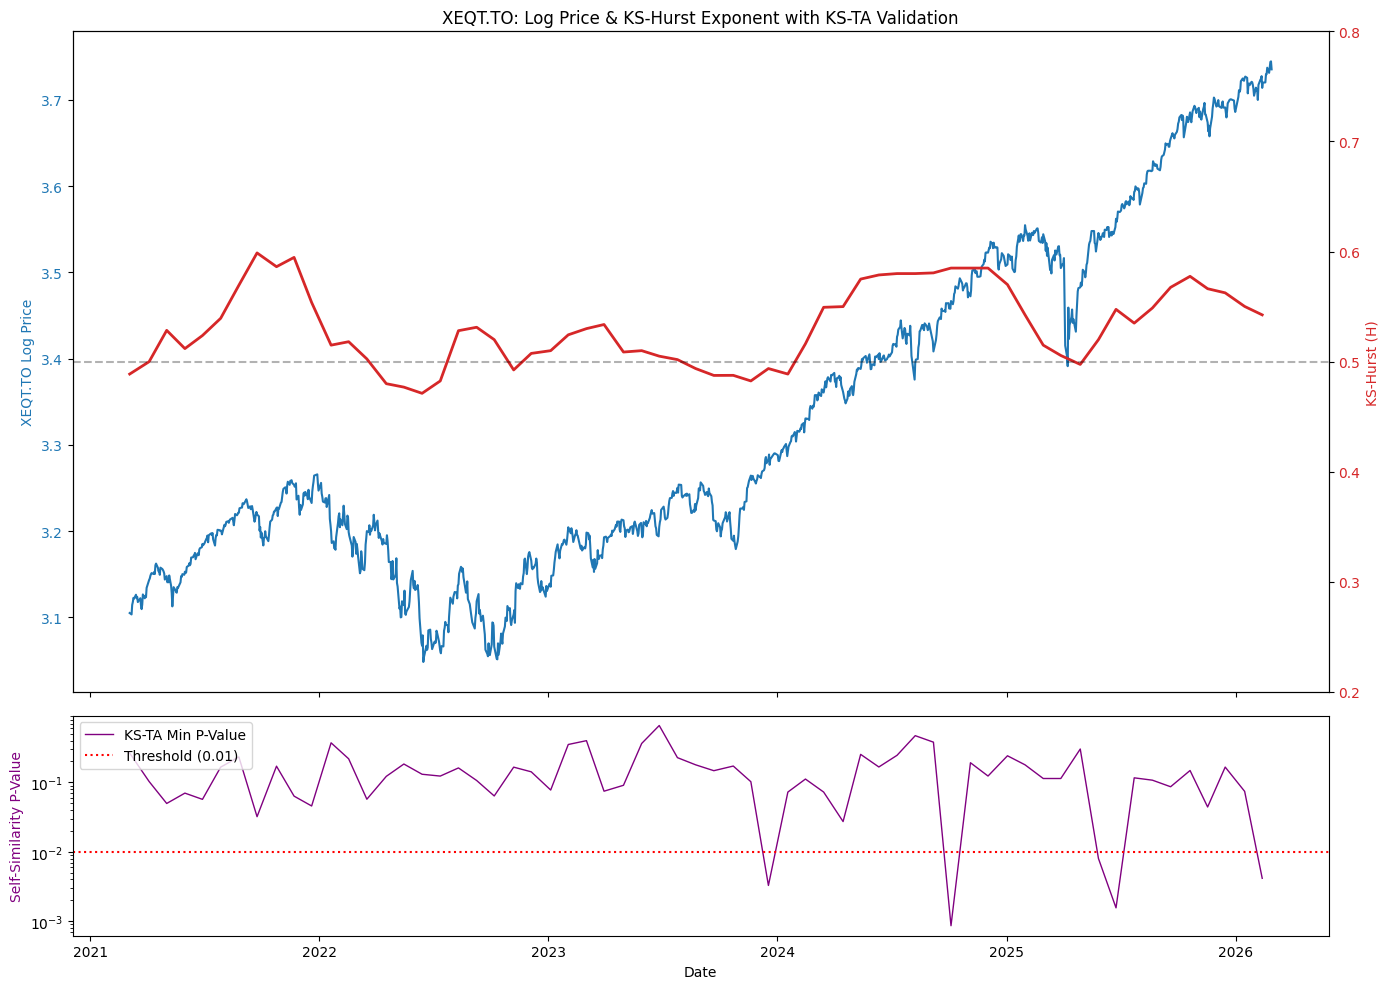

In [20]:
# Download financial data
tickers = ["^GSPC", "XEQT.TO"]
window_size = 256
step_size = 20

for ticker in tickers:
    data = yf.download(ticker, period="6y", auto_adjust=False)
    if data.empty: continue

    prices = data['Adj Close']
    log_prices_series = np.log(prices)
    log_prices = log_prices_series.values

    dates, rolling_h, rolling_p, rolling_std = [], [], [], []

    # Calculate rolling Hurst and p-value
    for i in range(0, len(log_prices) - window_size, step_size):
        window_data = log_prices[i : i + window_size]

        # Estimate H with GHE
        h_val = KSGHE(window_data)

        # Validate H with TA
        p_val = self_similarity_test_TA(window_data, h_val)

        rolling_h.append(h_val)
        rolling_p.append(p_val)
        dates.append(data.index[i + window_size])

    h_std = np.std(rolling_h)
    h_mean = np.mean(rolling_h)

    # Slice price dates to match the start of the Hurst dates
    start_date = dates[0]
    prices_clipped = log_prices_series.loc[start_date:]

    # Plotting with two subplots: Hurst/Price and P-Value
    fig, (ax_top, ax_p) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                       gridspec_kw={'height_ratios': [3, 1]})

    # --- TOP PLOT: PRICE & HURST ---
    ax_top.set_ylabel(f'{ticker} Log Price', color='tab:blue')
    ax_top.plot(prices_clipped.index, prices_clipped, color='tab:blue', alpha=1, label='Log Price')
    ax_top.tick_params(axis='y', labelcolor='tab:blue')

    ax_h = ax_top.twinx()
    ax_h.set_ylabel('KS-Hurst (H)', color='tab:red')
    ax_h.plot(dates, rolling_h, color='tab:red', linewidth=2, label='Rolling KS-GHE(1) Hurst')
    ax_h.axhline(0.5, color='black', linestyle='--', alpha=0.3) # EMH Line
    ax_h.set_ylim(0.2, 0.8)
    ax_h.tick_params(axis='y', labelcolor='tab:red')

    # --- BOTTOM PLOT: SELF-SIMILARITY TEST ---
    ax_p.set_ylabel('Self-Similarity P-Value', color='purple')
    ax_p.plot(dates, rolling_p, color='purple', linewidth=1, label='KS-TA Min P-Value')
    # 0.01 threshold for 99% confidence level
    ax_p.axhline(0.01, color='red', linestyle=':', label='Threshold (0.01)')
    ax_p.set_yscale('log')
    ax_p.set_xlabel('Date')
    ax_p.legend(loc='upper left')

    print(f"\n--- Statistics for {ticker} ---")
    print(f"Mean KS-GHE Hurst: {h_mean:.4f}")
    print(f"Standard Deviation: {h_std:.4f}")

    plt.title(f"{ticker}: Log Price & KS-Hurst Exponent with KS-TA Validation")
    fig.tight_layout()

    fig.tight_layout()
    plt.show()